🔵 Training model WITHOUT dropout


Epoch 1/5 - Train Acc: 96.02% | Test Acc: 98.52% | Frobenius Norm: 113.78


Epoch 2/5 - Train Acc: 98.23% | Test Acc: 98.12% | Frobenius Norm: 115.20


Epoch 3/5 - Train Acc: 98.63% | Test Acc: 98.54% | Frobenius Norm: 116.96


Epoch 4/5 - Train Acc: 98.92% | Test Acc: 98.78% | Frobenius Norm: 119.05


Epoch 5/5 - Train Acc: 99.01% | Test Acc: 98.87% | Frobenius Norm: 122.00

🟢 Training model WITH dropout


Epoch 1/5 - Train Acc: 92.27% | Test Acc: 98.54% | Frobenius Norm: 113.91


Epoch 2/5 - Train Acc: 97.53% | Test Acc: 98.51% | Frobenius Norm: 115.32


Epoch 3/5 - Train Acc: 98.09% | Test Acc: 98.10% | Frobenius Norm: 117.06


Epoch 4/5 - Train Acc: 98.47% | Test Acc: 98.82% | Frobenius Norm: 119.03


Epoch 5/5 - Train Acc: 98.68% | Test Acc: 98.95% | Frobenius Norm: 121.51


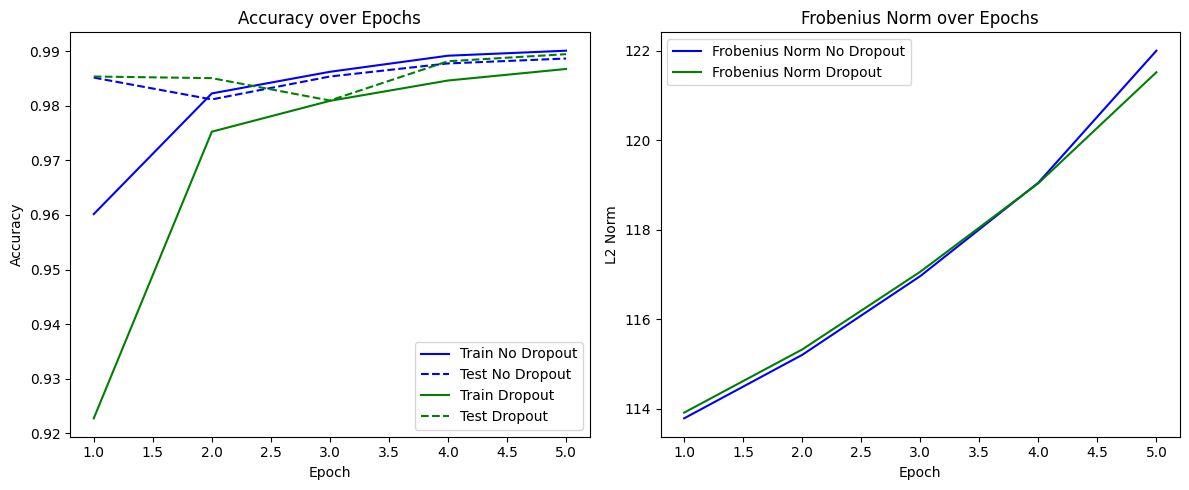

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define ResNet18 model with optional dropout
def get_resnet18(num_classes=10, use_dropout=False):
    model = models.resnet18(weights=None)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    if use_dropout:
        model.layer1 = nn.Sequential(model.layer1, nn.Dropout(0.5))
        model.layer2 = nn.Sequential(model.layer2, nn.Dropout(0.5))
    return model

def compute_frobenius_norm(model):
    weights = [param for name, param in model.named_parameters() if 'weight' in name]
    all_weights = torch.cat([w.flatten() for w in weights])
    return torch.norm(all_weights, p=2).item()

def train_model(model, optimizer, train_loader, test_loader, epochs=5, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    train_acc, test_acc, frob_norms = [], [], []

    for epoch in range(epochs):
        model.train()
        correct_train, total_train = 0, 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", leave=False)
        for inputs, targets in train_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == targets).sum().item()
            total_train += targets.size(0)
            train_bar.set_postfix(loss=loss.item())

        train_acc.append(correct_train / total_train)

        model.eval()
        correct_test, total_test = 0, 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                correct_test += (predicted == targets).sum().item()
                total_test += targets.size(0)
        test_acc.append(correct_test / total_test)
        frob_norms.append(compute_frobenius_norm(model))

        print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc[-1]*100:.2f}% | "
              f"Test Acc: {test_acc[-1]*100:.2f}% | Frobenius Norm: {frob_norms[-1]:.2f}")

    return train_acc, test_acc, frob_norms

# Load MNIST
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train both models
print("🔵 Training model WITHOUT dropout")
model_no_dropout = get_resnet18(use_dropout=False)
optimizer_no = optim.Adam(model_no_dropout.parameters(), lr=0.001)
train_acc_no, test_acc_no, frob_no = train_model(model_no_dropout, optimizer_no, train_loader, test_loader, epochs=5, device=device)

print("\n🟢 Training model WITH dropout")
model_dropout = get_resnet18(use_dropout=True)
optimizer_do = optim.Adam(model_dropout.parameters(), lr=0.001)
train_acc_do, test_acc_do, frob_do = train_model(model_dropout, optimizer_do, train_loader, test_loader, epochs=5, device=device)

# Plot
epochs_range = range(1, 6)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc_no, label='Train No Dropout', color='blue')
plt.plot(epochs_range, test_acc_no, label='Test No Dropout', linestyle='--', color='blue')
plt.plot(epochs_range, train_acc_do, label='Train Dropout', color='green')
plt.plot(epochs_range, test_acc_do, label='Test Dropout', linestyle='--', color='green')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, frob_no, label='Frobenius Norm No Dropout', color='blue')
plt.plot(epochs_range, frob_do, label='Frobenius Norm Dropout', color='green')
plt.title("Frobenius Norm over Epochs")
plt.xlabel("Epoch")
plt.ylabel("L2 Norm")
plt.legend()

plt.tight_layout()
plt.show()
